# Convolution Neural Network Using TensorFlow

TensorFlow is Google Brain Teams's open source libary for machine learning. Here I will code a convolutional neural network to classify the fashion MNIST dataset as the regular MNIST dataset has been done too many times. I decided to use a convolutional neural network as it is better for working with images. Convolutional neural networks use filters in order to detect features that can help with the training.

## Processing the data

In [2]:
import gzip as gz
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random

The dataset I used contained 60000 images of 10 different types of fashion items such as clothes and shoes an can be found at: https://github.com/zalandoresearch/fashion-mnist with each image labeled with what kind of fashion item it is. It is the same as the MNIST dataset but with fashion instead. It uses the exact same format as the MNIST dataset just with different images. First the files are loaded

In [7]:
train_x = gz.open("Data/train-images-idx3-ubyte.gz", "r")
train_y = gz.open("Data/train-labels-idx1-ubyte.gz", "r")

We set the size of the images (which are 28x28) and the number of images

In [8]:
img_size = 28
num_images = 60000

The data is stored in a sequence of bytes. The first 16 bytes are read but not assigned any value since they do not contain any usable data (as said in the original MNIST dataset website: http://yann.lecun.com/exdb/mnist/) then it reads the data in such a way that every training example is separated. Finally it reshapes it into a usable format.

In [9]:
train_x.read(16)  # First 16 bytes contain unecessary information
train_x = train_x.read(img_size * img_size * num_images)
train_x = np.frombuffer(train_x, dtype=np.uint8())
train_x = train_x.reshape(num_images, img_size, img_size)

Same concept for the labels but it is converted to a list instead of a numpy array.

In [10]:
train_y.read(8)  # First 8 bytes contain unecessary info
train_y = train_y.read(num_images)
train_y = np.frombuffer(train_y, dtype=np.uint8)
train_y = train_y.tolist()

Here each label is assinged a row (but idealy should be row) matrix with all 0s expect for one element. Each element shows the probability of it being that label so for example a picture of a pullover is labeled as a 2 (labels range from 0 to 9) then the third element (python starts counting from 0 so the first element is indexed as teh 0th element) is going to be a 1.
$$
\begin{bmatrix}
P(Shirt) \\
P(Trouser) \\
P(Pullover \\
\vdots \\
P(Ankle boot)
\end{bmatrix}
$$

In [11]:
for i in range(len(train_y)):
    index = train_y[i]
    train_y[i] = np.zeros((1, 10), dtype=np.float32)
    np.put(train_y[i], index, 1)

Then the data is saved

In [12]:
np.save("Data/train_features.npy", train_x)
np.save("Data/train_labels.npy", train_y)

The image data can be visualy shown.

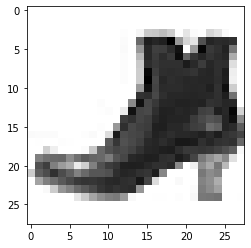

In [17]:
plt.imshow(tf.squeeze(train_x[np.random.randint(0, len(train_y))]), cmap="binary")
plt.show()

## The model

First the data is loaded and converted to tensors. A new axis is added to repressent the amount of colour channels so the dimension in general are: width $\times$ height $\times$ number of colour channels. The data is shuffled which makes the machine learn to fit all the data not just the first types, and batched so that I don't get an out of memory issue.

In [3]:
train_x = np.load("Data/train_features.npy")
train_y = np.load("Data/train_labels.npy")
# c = list(zip(train_x, train_y))
# random.shuffle(c)
# train_x, train_y = zip(*c)
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
train_x = train_x / 255.0
train_x = train_x[..., tf.newaxis]
train_y = tf.convert_to_tensor(train_y, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(1000).batch(32)

In [4]:
class TrainModel(tf.keras.Model):
    def __init__(self):
        super(TrainModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, 3, activation="relu")
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation="relu")
        self.d2 = tf.keras.layers.Dense(32, activation="relu")
        self.d3 = tf.keras.layers.Dense(10, activation="softmax")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

model = TrainModel()

In [5]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
accuracy = tf.keras.metrics.Accuracy()
train_loss = tf.keras.metrics.Mean()

In [6]:
@tf.function  # This just increases performance
def TrainStep(data_in, data_out):
    with tf.GradientTape() as g:
        preds = model(data_in)
        loss_funct = loss(data_out, preds)
    gradients = g.gradient(loss_funct, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    accuracy(tf.squeeze(data_out), preds)
    train_loss(loss_funct)

In [13]:
def train(dataset, epochs):
    for epoch in range(epochs):
        accuracy.reset_states()
        train_loss.reset_states()

        for img, labels in dataset:
            TrainStep(img, labels)

        placeholder = "Epoch: {}, Loss: {}, Accuracy: {} %"
        print(placeholder.format(epoch + 1, train_loss.result(), np.around(accuracy.result()*100, decimals=1)))

In [9]:
# Just messing with tensorflows gradient tape
x = tf.constant(5.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = 2*x**2 + 5*x
dy_dx = g.gradient(y, x)

In [10]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=25.0>

In [16]:
train(train_ds, 15)

Epoch: 1, Loss: 0.010215820744633675, Accuracy: 28.5 %
Epoch: 2, Loss: 0.01064203679561615, Accuracy: 28.200000762939453 %
Epoch: 3, Loss: 0.011628749780356884, Accuracy: 28.299999237060547 %
Epoch: 4, Loss: 0.011766750365495682, Accuracy: 29.799999237060547 %
Epoch: 5, Loss: 0.010643944144248962, Accuracy: 30.700000762939453 %
Epoch: 6, Loss: 0.013059194199740887, Accuracy: 29.0 %
Epoch: 7, Loss: 0.010710659436881542, Accuracy: 29.799999237060547 %
Epoch: 8, Loss: 0.011056344024837017, Accuracy: 31.200000762939453 %
Epoch: 9, Loss: 0.01208242867141962, Accuracy: 31.799999237060547 %
Epoch: 10, Loss: 0.009612374007701874, Accuracy: 31.600000381469727 %
Epoch: 11, Loss: 0.006708370056003332, Accuracy: 30.799999237060547 %
Epoch: 12, Loss: 0.013408802449703217, Accuracy: 31.299999237060547 %
Epoch: 13, Loss: 0.009910215623676777, Accuracy: 32.29999923706055 %
Epoch: 14, Loss: 0.008611105382442474, Accuracy: 31.899999618530273 %
Epoch: 15, Loss: 0.008056191727519035, Accuracy: 32.20000076

In [18]:
model.save("Fashion.model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Fashion.model\assets
